In [1]:
# Cell 0 — Clean install (safe versions)
!apt-get -y install openjdk-11-jdk > /dev/null
!pip -q uninstall -y dataproc-spark-connect || true
!pip -q install pyspark==3.5.1 findspark openpyxl

import os, findspark, pyspark
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = pyspark.__path__[0]
findspark.init()

from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .appName("TwitterSentimentTrend-FULL")
         .config("spark.ui.showConsoleProgress", "false")
         # You can tune these if you have more/less RAM:
         .config("spark.sql.shuffle.partitions", "64")   # more partitions for 1GB+
         .config("spark.executor.memoryOverhead", "1024")
         .getOrCreate())
spark


In [2]:
# Local/VM path (single or many files)
CSV_PATH = "/content/twitter_tweets.csv"   # supports wildcards for many files

# OR HDFS / S3:
# CSV_PATH = "hdfs:///data/twitter/*.csv"
# CSV_PATH = "s3a://my-bucket/twitter/*.csv"



In [4]:
# --- Cell 2 — Read large CSV efficiently ---
from pyspark.sql import functions as F, types as T

# Predefine schema to avoid two full scans
schema = T.StructType([
    T.StructField("tweet_id",        T.StringType(),  True),
    T.StructField("user_id",         T.LongType(),    True),
    T.StructField("created_at",      T.StringType(),  True),
    T.StructField("language",        T.StringType(),  True),
    T.StructField("text",            T.StringType(),  True),
    T.StructField("hashtags",        T.StringType(),  True),
    T.StructField("topic",           T.StringType(),  True),
    T.StructField("like_count",      T.IntegerType(), True),
    T.StructField("retweet_count",   T.IntegerType(), True),
    T.StructField("reply_count",     T.IntegerType(), True),
    T.StructField("quote_count",     T.IntegerType(), True),
    T.StructField("sentiment_label", T.StringType(),  True),
    T.StructField("sentiment_score", T.DoubleType(),  True),
])

# Read CSV (safe for multi-GB, quoted fields, and newlines)
df_raw = (
    spark.read
        .option("header", True)
        .option("multiLine", True)
        .option("escape", '"')
        .option("mode", "PERMISSIVE")
        .schema(schema)  # always use schema for speed
        .csv(CSV_PATH)
        .repartition(256)  # tune partition count to cores/cluster
)

# Preview without triggering full scan
df_raw.limit(10).show(truncate=False)

# Print row/column count *approximation* without scanning all rows
# Use input file metadata instead of full count (if stored in a filesystem)
print("Approximate columns:", len(df_raw.columns))


+------------------------------------+-------+-------------------+--------+---------------------------------------------+------------------------------------+---------+----------+-------------+-----------+-----------+---------------+---------------+
|tweet_id                            |user_id|created_at         |language|text                                         |hashtags                            |topic    |like_count|retweet_count|reply_count|quote_count|sentiment_label|sentiment_score|
+------------------------------------+-------+-------------------+--------+---------------------------------------------+------------------------------------+---------+----------+-------------+-----------+-----------+---------------+---------------+
|21480623-1fea-4b24-9273-22a3737b4eee|4312267|2020-01-24T22:45:36|en      |Travel tip: Bali today 🏆                    |#Vacation,#Flights                  |travel   |26        |6            |28         |1          |negative       |0.041          |
|

In [5]:
# Cell 3 — Normalize names, cast types, tidy text
def normalize(name: str) -> str:
    return (name or "").strip().lower().replace(" ", "_").replace("-", "_")

df = df_raw.toDF(*[normalize(c) for c in df_raw.columns])

from pyspark.sql.types import IntegerType, DoubleType
for c in ["like_count","retweet_count","reply_count","quote_count","user_id"]:
    if c in df.columns: df = df.withColumn(c, F.col(c).cast(IntegerType()))
if "sentiment_score" in df.columns:
    df = df.withColumn("sentiment_score", F.col("sentiment_score").cast(DoubleType()))
if "language" in df.columns:
    df = df.withColumn("language", F.lower(F.col("language")))
if "topic" in df.columns:
    df = df.withColumn("topic", F.trim(F.regexp_replace("topic", r"\s+", " ")))
if "text" in df.columns:
    df = df.withColumn("text", F.regexp_replace("text", r"[^\x00-\x7F]+", ""))  # remove weird glyphs safely

# Fill sensible defaults
fills = {}
if "hashtags" in df.columns: fills["hashtags"] = ""
if "topic"    in df.columns: fills["topic"]    = "unknown"
if "language" in df.columns: fills["language"] = "unknown"
if "text"     in df.columns: fills["text"]     = ""
if fills: df = df.fillna(fills)

# Drop duplicate tweets if we have IDs
if "tweet_id" in df.columns:
    df = df.dropDuplicates(["tweet_id"])

df.select(*[c for c in ["tweet_id","language","topic","like_count","text"] if c in df.columns]).show(5, truncate=False)


+------------------------------------+--------+-------------+----------+-------------------------------+
|tweet_id                            |language|topic        |like_count|text                           |
+------------------------------------+--------+-------------+----------+-------------------------------+
|000cbc87-62cd-492a-b93f-83eb19b5e6cb|en      |politics     |5         |Debate on the minnnster today! |
|001687f1-d73f-4906-b954-d272ce2afa67|es      |education    |9         |Thesis progress: NLP today!!   |
|001b4c5e-838a-46e9-a001-f2e5d05d4e4e|en      |TECH         |4         |Thoughts on LLMs today         |
|001e32aa-3e7a-47ce-8e6e-d9dfbbcdc366|en      |entertainment|20        |Jst finished the series today!!|
|00200cf8-3981-4b86-9c1d-45bf25f194fa|en      |ENTERTAINMENT|10        |REVIEW: THE TRAILER TODAY!     |
+------------------------------------+--------+-------------+----------+-------------------------------+
only showing top 5 rows



In [6]:
# Cell 4 — Full-dataset time parsing
patterns = [
    "MM-dd-yyyy HH:mm", "dd-MM-yyyy HH:mm", "MM/dd/yyyy HH:mm",
    "yyyy-MM-dd'T'HH:mm:ss", "yyyy-MM-dd HH:mm:ss"
]
if "created_at" in df.columns:
    ts_cols = [F.to_timestamp("created_at", p) for p in patterns]
    df = df.withColumn("created_ts", F.coalesce(*ts_cols))
    df = df.dropna(subset=["created_ts"])
else:
    df = df.withColumn("created_ts", F.current_timestamp())

df.select("created_at","created_ts").show(10, truncate=False)


+-------------------+-------------------+
|created_at         |created_ts         |
+-------------------+-------------------+
|08/04/2022 10:55   |2022-08-04 10:55:00|
|10/12/2024 06:35   |2024-10-12 06:35:00|
|2023-03-30T10:52:59|2023-03-30 10:52:59|
|2020-05-18T20:41:50|2020-05-18 20:41:50|
|2022-04-03T07:53:03|2022-04-03 07:53:03|
|03/13/2023 21:54   |2023-03-13 21:54:00|
|2021-10-31T07:26:45|2021-10-31 07:26:45|
|2020-04-26T00:58:37|2020-04-26 00:58:37|
|01/02/2023 09:24   |2023-01-02 09:24:00|
|07/28/2021 02:26   |2021-07-28 02:26:00|
+-------------------+-------------------+
only showing top 10 rows



In [7]:
# Cell 5 — RDD step (bounded work)
rdd = df.select("hashtags").rdd.map(lambda r: r["hashtags"] or "")
tags = (rdd.flatMap(lambda s: [t.strip() for t in s.split(",") if t.strip() != ""])
          .map(lambda t: (t, 1))
          .reduceByKey(lambda a,b: a+b)
          .sortBy(lambda x: -x[1]))
top_hashtags = tags.take(20)
print(top_hashtags)


[('#Startups', 174), ('#Policy', 116), ('#Debate', 114), ('#Vacation', 112), ('#Elections', 108), ('#Stocks', 105), ('#Research', 105), ('#Crypto', 102), ('#EdTech', 100), ('#Health', 100), ('#Python', 100), ('#WorldCup', 99), ('#Wanderlust', 99), ('#Democracy', 99), ('#MentalHealth', 97), ('#Flights', 97), ('#Wellness', 95), ('#Economy', 94), ('#Tourism', 93), ('#University', 93)]


In [8]:
# Cell 6 — Register view
df.createOrReplaceTempView("tweets")


In [9]:
# Cell 7 — Daily tweets + sentiment mix
daily_sql = spark.sql("""
SELECT
  date_trunc('day', created_ts) AS day,
  COUNT(*) AS tweets,
  SUM(CASE WHEN sentiment_label='positive' THEN 1 ELSE 0 END) AS pos,
  SUM(CASE WHEN sentiment_label='negative' THEN 1 ELSE 0 END) AS neg,
  SUM(CASE WHEN sentiment_label='neutral'  THEN 1 ELSE 0 END) AS neu
FROM tweets
GROUP BY 1
ORDER BY 1
""")
daily_sql.show(10, truncate=False)


+-------------------+------+---+---+---+
|day                |tweets|pos|neg|neu|
+-------------------+------+---+---+---+
|2020-01-01 00:00:00|1     |1  |0  |0  |
|2020-01-04 00:00:00|1     |1  |0  |0  |
|2020-01-06 00:00:00|1     |0  |0  |1  |
|2020-01-07 00:00:00|1     |1  |0  |0  |
|2020-01-09 00:00:00|1     |0  |0  |1  |
|2020-01-11 00:00:00|1     |0  |0  |1  |
|2020-01-12 00:00:00|1     |0  |1  |0  |
|2020-01-13 00:00:00|2     |2  |0  |0  |
|2020-01-14 00:00:00|2     |2  |0  |0  |
|2020-01-15 00:00:00|2     |0  |2  |0  |
+-------------------+------+---+---+---+
only showing top 10 rows



In [10]:
# Cell 8 — Top topics by total engagement
trending_sql = spark.sql("""
SELECT
  topic,
  SUM(COALESCE(like_count,0) + COALESCE(retweet_count,0) + COALESCE(reply_count,0) + COALESCE(quote_count,0)) AS total_engagement,
  COUNT(*) AS posts
FROM tweets
WHERE topic IS NOT NULL AND topic <> ''
GROUP BY topic
ORDER BY total_engagement DESC
LIMIT 20
""")
trending_sql.show(20, truncate=False)


+-------------+----------------+-----+
|topic        |total_engagement|posts|
+-------------+----------------+-----+
|politics     |9413            |252  |
|travel       |9158            |245  |
|entertainment|8653            |224  |
|finance      |8515            |233  |
|health       |8334            |228  |
|education    |8321            |228  |
|sports       |7775            |228  |
|tech         |7720            |223  |
|unknown      |4345            |118  |
|TECH         |2622            |63   |
|FINANCE      |2113            |56   |
|SPORTS       |2107            |54   |
|POLITICS     |2078            |65   |
|TRAVEL       |2054            |52   |
|ENTERTAINMENT|1901            |57   |
|EDUCATION    |1897            |52   |
|HEALTH       |1822            |51   |
+-------------+----------------+-----+



In [16]:
# Cell 9 — Full-data classifier (HashingTF + LR)
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, VectorAssembler, StringIndexer, IndexToString
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark import StorageLevel

# Tame shuffle sizes for big data
spark.conf.set("spark.sql.shuffle.partitions", "64")

# Required columns
req = ["tweet_id", "text","topic","language","like_count","retweet_count","reply_count","quote_count","sentiment_label"]
have = [c for c in req if c in df.columns]
df_ml = df.select(*have).fillna({"topic":"unknown","language":"unknown","text":""})

# Indexers
label_indexer = StringIndexer(inputCol="sentiment_label", outputCol="label", handleInvalid="keep")
topic_indexer = StringIndexer(inputCol="topic",          outputCol="topic_idx", handleInvalid="keep")
lang_indexer  = StringIndexer(inputCol="language",       outputCol="lang_idx",  handleInvalid="keep")

# Text → tokens → stopwords → hashing (bounded features)
tokenizer = Tokenizer(inputCol="text", outputCol="tokens")
remover   = StopWordsRemover(inputCol="tokens", outputCol="clean_tokens")
tf        = HashingTF(inputCol="clean_tokens", outputCol="tf", numFeatures=(1<<18))  # 262,144 dims

assembler = VectorAssembler(
    inputCols=[c for c in ["tf","topic_idx","lang_idx","like_count","retweet_count","reply_count","quote_count"] if c in df_ml.columns],
    outputCol="features", handleInvalid="keep"
)

# Logistic Regression (probabilities available). Keep iter modest; increase if you have time.
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=12, regParam=0.0, elasticNetParam=0.0)

# Map prediction index → original label text for readability
label_to_text = IndexToString(inputCol="prediction", outputCol="predicted_label", labels=[])

pipeline = Pipeline(stages=[label_indexer, topic_indexer, lang_indexer, tokenizer, remover, tf, assembler, lr, label_to_text])

# Split (on full data)
train_df, test_df = df_ml.randomSplit([0.8, 0.2], seed=42)

# Repartition moderately for stable shuffles (avoid huge single partitions)
train_df = train_df.repartition(64)
test_df  = test_df.repartition(64)

# Optional: persist training set to reduce recomputation
train_df = train_df.persist(StorageLevel.MEMORY_AND_DISK)

model = pipeline.fit(train_df)

# Set proper labels on the IndexToString stage
model.stages[-1].setLabels(model.stages[0].labels)

pred = model.transform(test_df)

# Show results (small sample)
pred.select("text","sentiment_label","predicted_label","prediction","probability").show(10, truncate=False)

# Metrics
eA = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
eF = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
print(f"Accuracy: {eA.evaluate(pred):.3f} | F1: {eF.evaluate(pred):.3f}")

+--------------------------------------------+---------------+---------------+----------+----------------------------------------------------------------------------------+
|text                                        |sentiment_label|predicted_label|prediction|probability                                                                       |
+--------------------------------------------+---------------+---------------+----------+----------------------------------------------------------------------------------+
|Must-watch: the movie today                 |neutral        |positive       |0.0       |[0.37878151333462495,0.3203483795262533,0.30069685681200387,1.73250327117846E-4]  |
|Just finished the cast today                |neutral        |positive       |0.0       |[0.378715103049895,0.312339405699548,0.30877154246764926,1.7394878290788478E-4]   |
|Visa update: Kerala today                   |positive       |positive       |0.0       |[0.3808721023765087,0.3152547007963424,0.30369

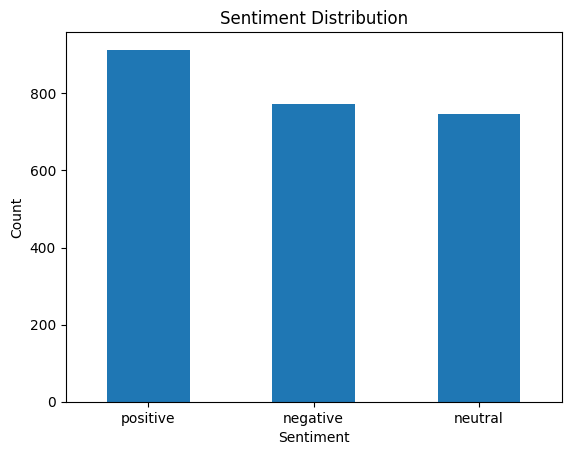

In [17]:
# Cell 10 — Sentiment distribution
import matplotlib.pyplot as plt

if "sentiment_label" in df.columns:
    sent_df = (df.groupBy("sentiment_label").count()
                 .orderBy(F.desc("count"))
                 .limit(50)           # tiny
                 .toPandas())
    sent_df.plot(kind="bar", x="sentiment_label", y="count", legend=False)
    plt.title("Sentiment Distribution"); plt.xlabel("Sentiment"); plt.ylabel("Count"); plt.xticks(rotation=0)
    plt.show()


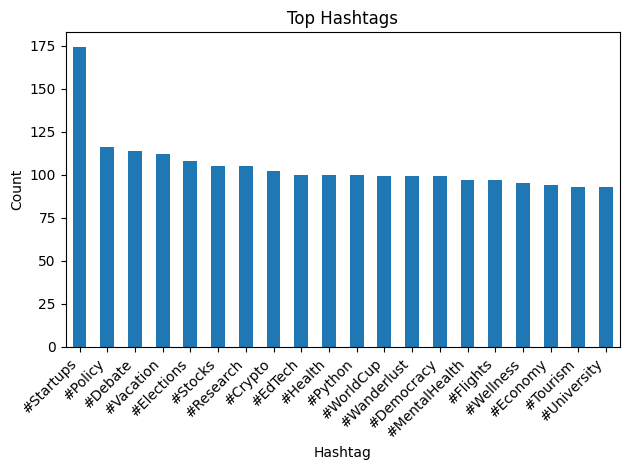

In [18]:
# Cell 11 — Top hashtags bar chart
if top_hashtags:
    top_tags_pdf = spark.createDataFrame(top_hashtags, ["tag","count"]).toPandas()
    top_tags_pdf.plot(kind="bar", x="tag", y="count", legend=False)
    plt.title("Top Hashtags"); plt.xlabel("Hashtag"); plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right"); plt.tight_layout()
    plt.show()


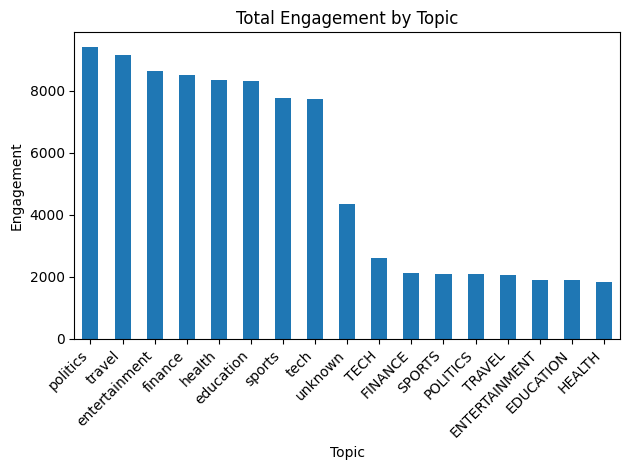

In [19]:
# Cell 12 — Engagement by topic
topic_eng_pdf = trending_sql.toPandas()  # already limited to 20 topics
topic_eng_pdf.plot(kind="bar", x="topic", y="total_engagement", legend=False)
plt.title("Total Engagement by Topic"); plt.xlabel("Topic"); plt.ylabel("Engagement")
plt.xticks(rotation=45, ha="right"); plt.tight_layout()
plt.show()


In [21]:
# Save Spark results as CSV
pred.select("tweet_id","text","sentiment_label","prediction") \
    .write.mode("overwrite").option("header", True).csv("/content/predictions_csv")

# (Optional) Save model for reuse
model.write().overwrite().save("/content/sentiment_pipeline_model")
print("Saved: /content/predictions_csv and /content/sentiment_pipeline_model")

Saved: /content/predictions_csv and /content/sentiment_pipeline_model
